# Exercise 8: Anomaly Detection and Recommender Systems

In this exercise, has two major parts:
1. Anomaly detection to detect failing servers on a network.
2. Recommender system based on collaborative filtering to predict a movie ratings.

Files provided by Coursera, located under `../exercises/ex1-ex8-octave/ex8`

- `ex8.m` - Octave/MATLAB script for first part of exercise
- `ex8_cofi.m` - Octave/MATLAB script for second part of exercise
- `ex8data1.mat` - First example Dataset for anomaly detection
- `ex8data2.mat` - Second example Dataset for anomaly detection
- `ex8_movies.mat` - Movie Review Dataset
- `ex8_movieParams.mat` - Parameters provided for debugging
- `multivariateGaussian.m` - Computes the probability density function for a Gaussian distribution
- `visualizeFit.m` - 2D plot of a Gaussian distribution and a dataset
- `checkCostFunction.m` - Gradient checking for collaborative filtering
- `computeNumericalGradient.m` - Numerically compute gradients
- `fmincg.m` - Function minimization routine (similar to fminunc)
- `loadMovieList.m` - Loads the list of movies into a cell-array
- `movie_ids.txt` - List of movies
- `normalizeRatings.m` - Mean normalization for collaborative filtering
- `submit.m` - Submission script that sends your solutions to our servers

Files to complete:

- `estimateGaussian.m` - Estimate the parameters of a Gaussian ditribution with a diagonal covariance matrix
- `selectThreshold.m` - Find a threshold for anomaly detection
- `cofiCostFunc.m` - Implement the cost function for collaborative filtering

Workflow:

- Download latest Octave version of exercise from Coursera
- Complete code in exercise files following `ex8.pdf`
- Whenever an exercise part is finished
  - Check it with `ex8` and `ex8_cofi` in Octave terminal
  - Create a submission token on Coursera (exercise submission page, it lasts 30 minutes)
  - Execute `submit` in Octave terminal
  - Introduce email and token
  - Results appear

**Overview of contents:**

0. Setup: `gnuplot`
1. Dataset Loading & Visualization
2. Anomaly Detection - `ex8.m`
    - 2.1 Gaussian Distribution: Parameters - `estimateGaussian.m`
    - 2.2 Selecting the Threshold `epsilon` - `selectThreshold.m`

## 0. Setup: `gnuplot`

In [5]:
graphics_toolkit ("gnuplot");

In [6]:
%plot -b inline:gnuplot

## 1. Dataset Loading & Visualization

In [10]:
% Load the dataset
clear all;
load('ex8data1.mat');

In [13]:
who

Variables visible from the current scope:

X     Xval  yval



In [15]:
% Features: throughput (MB/s), latency (ms)
% m = 307 exammples
size(X)

ans =

   307     2



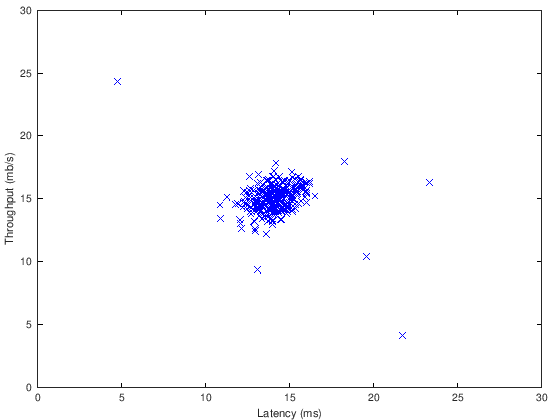

In [16]:
% Visualize the example dataset
plot(X(:, 1), X(:, 2), 'bx');
axis([0 30 0 30]);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

## 2. Anomaly Detection - `ex8.m`

### 2.1 Gaussian Distribution: Parameters - `estimateGaussian.m`

$$\{x^{(1)}, \dots, x^{(j)}, \dots, x^{(m)} \}, \,\,\, x^{(j)} \in \mathbb{R}^n, \,\,\, j = 1 \dots m$$

$$x^{(j)} = [x^{(j)}_1, \dots, x^{(j)}_i, \dots, x^{(j)}_n]^T, \,\,\, i = 1 \dots n$$

$$\mu_i, \,\,\, \sigma_i^2$$

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$

In [24]:
function [mu sigma2] = estimateGaussian_(X)
    % [mu sigma2] = estimateGaussian(X), 
    % The input X is the dataset with each n-dimensional data point in one row
    % The output is an n-dimensional vector mu, the mean of the data set
    % and the variances sigma^2, an n x 1 vector

    % Useful variables
    [m, n] = size(X);

    % You should return these values correctly
    mu = zeros(n, 1);
    sigma2 = zeros(n, 1);

    mu = mean(X)';
    sigma2 = var(X,1)'; % normalize using (m-1) instead of m
end

In [25]:
%  Estimate my and sigma2
[mu sigma2] = estimateGaussian_(X);

In [26]:
mu

mu =

   14.112
   14.998



In [27]:
sigma2

sigma2 =

   1.8326
   1.7097



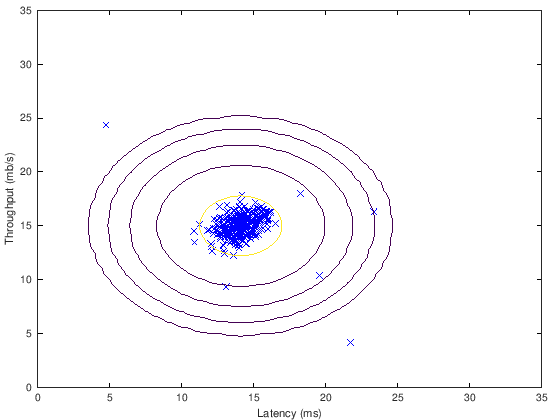

In [28]:
%  Visualize the fit
visualizeFit(X,  mu, sigma2);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

### 2.2 Selecting the Threshold `epsilon` - `selectThreshold.m`

In [49]:
function [bestEpsilon bestF1] = selectThreshold_(yval, pval)
    % [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    % threshold to use for selecting outliers based on the results from a
    % validation set (pval) and the ground truth (yval).

    bestEpsilon = 0;
    bestF1 = 0;
    F1 = 0;

    stepsize = (max(pval) - min(pval)) / 1000;
    for epsilon = min(pval):stepsize:max(pval)
    
        cvPredictions = (pval < epsilon); % 1 if anomaly: p < epsilon!

        tp = sum((cvPredictions == yval) & (yval == 1));
        tn = sum((cvPredictions == yval) & (yval == 0));
        fp = sum((cvPredictions != yval) & (yval == 0));
        fn = sum((cvPredictions != yval) & (yval == 1));

        precision = tp / (tp + fp);
        recall = tp / (tp + fn);
        F1 = 2*precision*recall / (precision+recall);

        if F1 > bestF1
           bestF1 = F1;
           bestEpsilon = epsilon;
        end
    end

end

In [54]:
% Provided in the course
% Since sigma2 is a vector, Sigma is constructed as a diagonal matrix
% thus, the multivariate Gaussian is equivalent to the univariate!
% For more info, look in the code :)
pval = multivariateGaussian(Xval, mu, sigma2);

In [58]:
[epsilon F1] = selectThreshold_(yval, pval)

epsilon = 8.9909e-05
F1 = 0.8750


In [59]:
% Compute the model (again)
[mu sigma2] = estimateGaussian(X);
p = multivariateGaussian(X, mu, sigma2);

In [60]:
% Find the outliers in the training set and plot the
outliers = find(p < epsilon);

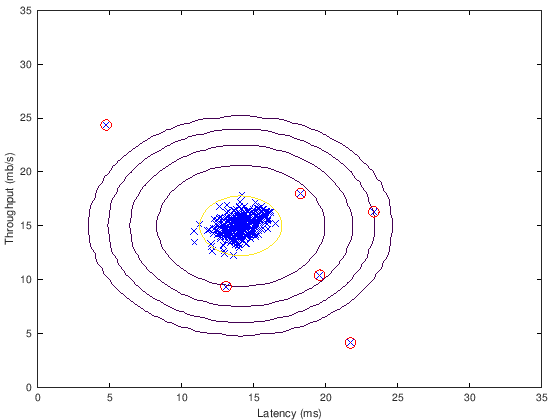

In [62]:
% Plot the ooutliers
visualizeFit(X,  mu, sigma2);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');
hold on;
plot(X(outliers, 1), X(outliers, 2), 'ro', 'LineWidth', 2, 'MarkerSize', 10);
hold off;